In [1]:
%load_ext rpy2.ipython
from IPython.display import FileLink

In [2]:
%%R
library(dplyr); library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



###These files are from the [l2fc sparsity notebook](./Sparsity_make_l2fc_table.ipynb) and [l2fc no sparsity notebook](./l2fc_table_nospar.ipynb)

In [3]:
%%R
l2fc.all = read.csv("data/l2fc_table_no_spar.csv")
l2fc.filtered = read.csv("data/l2fc_table.csv")

In [4]:
%%R
head(l2fc.all)

  Day Treatment       OTU log2FoldChange    lfcSE    Rank1          Rank2
1  14      13CC OTU.14353             NA       NA Bacteria  Acidobacteria
2  14      13CC OTU.11642     -0.9017218 1.536176 Bacteria           <NA>
3  14      13CC  OTU.9532             NA       NA Bacteria Proteobacteria
4  14      13CC OTU.12098             NA       NA Bacteria Proteobacteria
5  14      13CC OTU.12051             NA       NA Bacteria Proteobacteria
6  14      13CC OTU.12843             NA       NA Bacteria Proteobacteria
                Rank3        Rank4          Rank5                Rank6
1               DA023         <NA>           <NA>                 <NA>
2                <NA>         <NA>           <NA>                 <NA>
3 Deltaproteobacteria Myxococcales       MSB-4B10                 <NA>
4 Deltaproteobacteria Myxococcales       MSB-4B10                 <NA>
5 Deltaproteobacteria Myxococcales Nannocystineae        Haliangiaceae
6 Deltaproteobacteria Myxococcales       MSB-4B10 uncult

In [5]:
%%R
head(l2fc.filtered)

  sparsity_threshold Day Treatment      OTU log2FoldChange         p    Rank1
1               0.45  14      13CC OTU.4204    -0.20588818 0.9999657 Bacteria
2               0.45  14      13CC  OTU.467    -0.30402392 0.9999980 Bacteria
3               0.45  14      13CC  OTU.905     0.08372895 0.9763679 Bacteria
4               0.45  14      13CC OTU.7253     0.12803079 0.9657952 Bacteria
5               0.45  14      13CC   OTU.67    -0.52084841 0.9999991 Bacteria
6               0.45  14      13CC OTU.4907     0.14386449 0.9994238 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria DA023 

In [11]:
%%R
FDR = 0.10

d1 = l2fc.filtered %>%
    filter(Treatment %in% c("13CC", "13C100")) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = sum(minP <= FDR)) %>%
    mutate(rspnse.t = ifelse(rspnse == 2, "yes", "no"))

rspndrs = unique(d1$OTU)

d2 = l2fc.all %>%
    filter(Treatment %in% c("13CC", "13C100")) %>%
    group_by(OTU, Rank2, Rank3, Treatment) %>%
    summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
    group_by() %>%
    spread(Treatment, max.l2fc)

d = left_join(d1, d2)
d

Joining by: "OTU"
Source: local data frame [403 x 7]

         OTU rspnse rspnse.t          Rank2                          Rank3
1      OTU.1      1       no Actinobacteria                  Micrococcales
2     OTU.10      2      yes Proteobacteria            Alphaproteobacteria
3  OTU.10036      1       no Planctomycetes               Planctomycetacia
4   OTU.1009      1       no  Bacteroidetes               Sphingobacteriia
5    OTU.101      1       no Actinobacteria               Streptomycetales
6  OTU.10167      2      yes  Acidobacteria Candidatus_Chloracidobacterium
7    OTU.102      2      yes  Bacteroidetes               Sphingobacteriia
8  OTU.10228      1       no  Bacteroidetes                     Cytophagia
9   OTU.1029      1       no Planctomycetes                          OM190
10  OTU.1032      2      yes  Bacteroidetes               Sphingobacteriia
..       ...    ...      ...            ...                            ...
Variables not shown: 13C100 (dbl), 13CC (dbl)


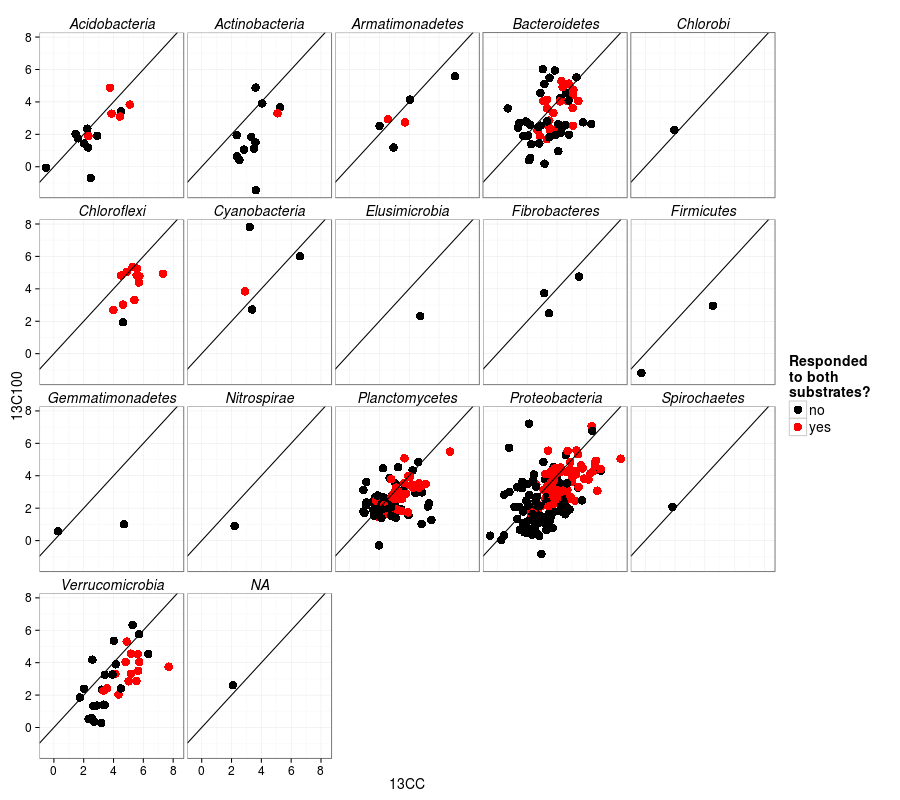

In [12]:
%%R -w 900 -h 800

p = ggplot(d, aes(x = `13CC`, y = `13C100`, color = rspnse.t))

p = p + scale_color_manual(values = c("black", "red"))

p = p + facet_wrap(~Rank2)

p = p + geom_point(size = 4)

p = p + geom_abline(intercept = 0)

p = p + theme_bw()

p = p + labs(color = "Responded\nto both\nsubstrates?")

p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 14, face = "italic"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 14))

p

In [13]:
%%R
FDR = 0.10

df.rspndrs = read.csv("data/l2fc_table.csv") %>%
    filter(Treatment %in% c("13CC", "13C100")) %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "Cellulose Only", "RE Pulse"))
}

df.rspndrs$rspnse = apply(df.rspndrs[,c("13CC", "13C100")], 1, rspnse)

df.rspndrs = df.rspndrs %>% select(OTU, rspnse)

df.rspndrs

Source: local data frame [403 x 2]

         OTU         rspnse
1      OTU.1 Cellulose Only
2     OTU.10           Both
3  OTU.10036       RE Pulse
4   OTU.1009       RE Pulse
5    OTU.101 Cellulose Only
6  OTU.10167           Both
7    OTU.102           Both
8  OTU.10228 Cellulose Only
9   OTU.1029       RE Pulse
10  OTU.1032           Both
..       ...            ...


In [15]:
%%R
df.100 = l2fc.all %>%
        filter(Treatment %in% c("13CC", "13C100")) %>%
        left_join(df.rspndrs) %>%
        group_by(Rank2) %>%
        mutate(phylum.rspnse = ifelse(sum(!is.na(rspnse)) > 0, "rspndr", "none")) %>%
        filter(phylum.rspnse == "rspndr") %>%
        group_by(OTU, Rank2, Rank3, Treatment) %>%
        summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
        group_by() %>%
        spread(Treatment, max.l2fc) %>%
        left_join(df.rspndrs)
print(df.100)

Joining by: "OTU"
Joining by: "OTU"
Source: local data frame [9,846 x 6]

         OTU          Rank2               Rank3      13C100        13CC
1      OTU.1 Actinobacteria       Micrococcales  0.42411193  2.53194715
2     OTU.10 Proteobacteria Alphaproteobacteria  4.28455713  5.26551206
3    OTU.100 Actinobacteria     Thermoleophilia -1.08095557 -0.70128335
4   OTU.1000 Actinobacteria Propionibacteriales  0.06468909  0.03255133
5  OTU.10000 Proteobacteria Deltaproteobacteria  1.87777612 -0.64237617
6  OTU.10009 Proteobacteria  Betaproteobacteria          NA          NA
7   OTU.1001 Proteobacteria Deltaproteobacteria -0.32550574  2.04268588
8  OTU.10015 Planctomycetes    Planctomycetacia          NA  0.90396514
9  OTU.10016 Proteobacteria Alphaproteobacteria          NA          NA
10 OTU.10017  Acidobacteria               DA023          NA          NA
..       ...            ...                 ...         ...         ...
Variables not shown: rspnse (chr)


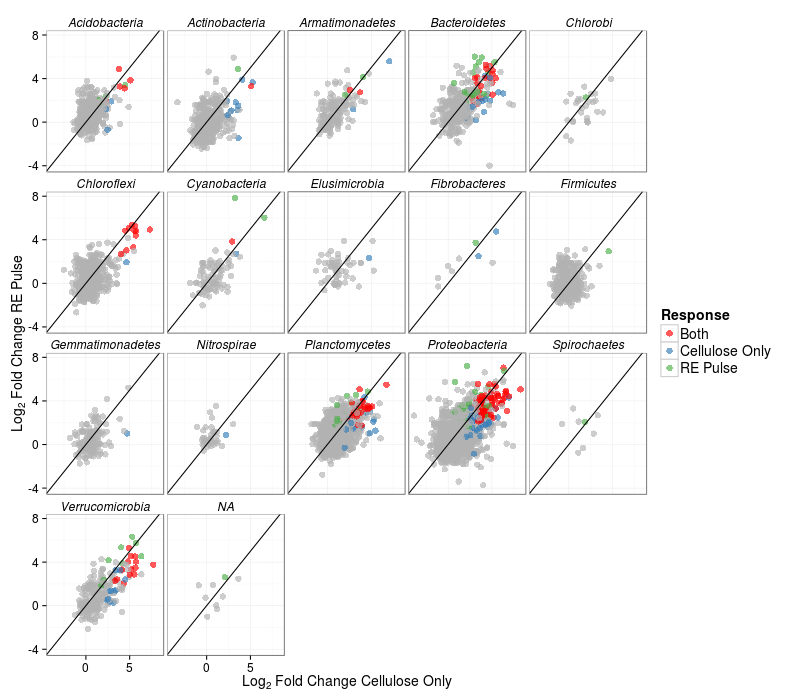

In [18]:
%%R -w 800 -h 700
FDR = 0.10

colours = c("red", "#377eb8", "#4daf4a")

p = ggplot(df.100, aes(x = `13CC`, y = `13C100`, color = rspnse))

#p = p + scale_color_manual(values = c("black", "red"))

p = p + facet_wrap(~Rank2)

p = p + geom_point(size = 3, alpha = 0.65)

p = p + geom_abline(intercept = 0)

p = p + scale_color_manual(values = colours, na.value = "grey70")

p = p + theme_bw()

p = p + labs(color = "Response")

p = p + labs(y = expression(paste("", Log[2]," Fold Change"," RE Pulse",sep="")), 
             x = expression(paste("", Log[2]," Fold Change"," Cellulose Only",sep="")))


p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 12, face = "italic"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 14))

p